**Математические модели**

Прежде чем кодировать реализацию, зафиксируем уравнения, которые будут использоваться в методе step:

- SimpleIntegrate (IF): Самая простая модель без утечки.

$$\frac{dV}{dt} = I$$

- LIF (Leaky Integrate-and-Fire): Добавляется "утечка" — потенциал стремится к состоянию покоя $V_{rest}$.

$$\tau_m \frac{dV}{dt} = -(V - V_{rest}) + R \cdot I$$

- Izhikevich: Двумерная система, позволяющая имитировать сложные паттерны (пачки импульсов, адаптацию).

$$\begin{cases} \frac{dv}{dt} = 0.04v^2 + 5v + 140 - u + I \\ \frac{du}{dt} = a(bv - u) \end{cases}$$

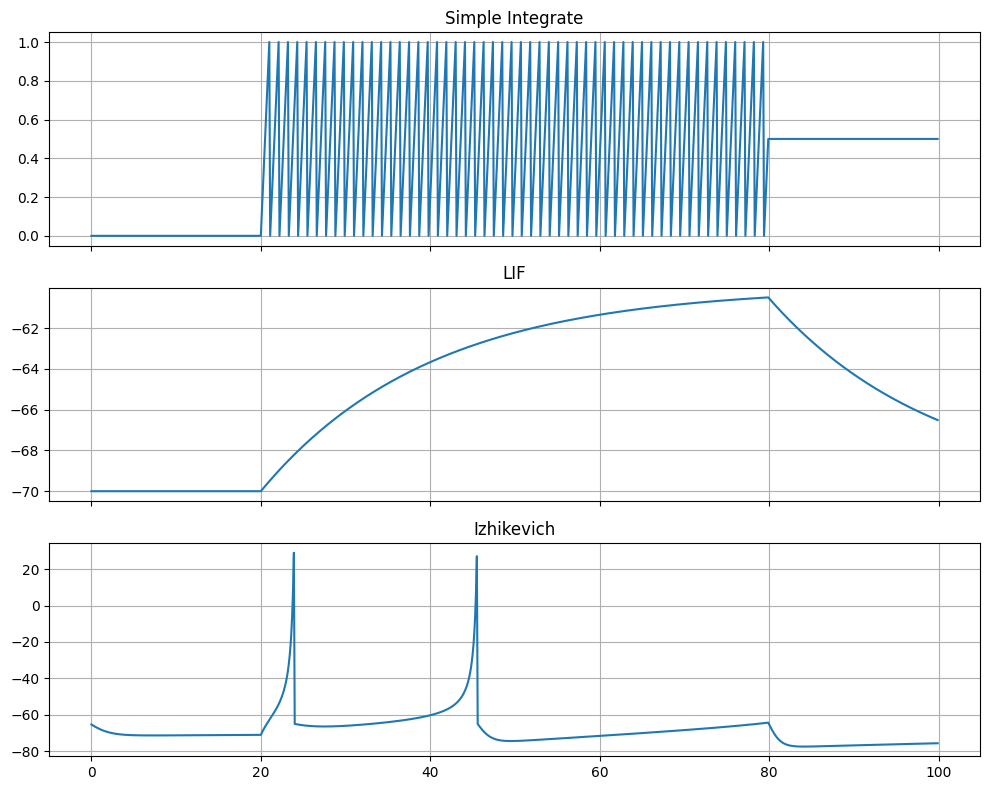

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class LIFNeuron:
    def __init__(self, tau=20.0, v_rest=-70.0, v_thresh=-50.0, v_reset=-80.0):
        self.tau, self.v_rest, self.v_thresh, self.v_reset = tau, v_rest, v_thresh, v_reset
        self.v = v_rest

    def step(self, I, dt=1.0):
        # Уравнение утечки + входной ток
        dv = (-(self.v - self.v_rest) + I) / self.tau * dt
        self.v += dv
        
        spike = self.v >= self.v_thresh
        if spike:
            self.v = self.v_reset
        return self.v, spike

class IzhikevichNeuron:
    def __init__(self, a=0.02, b=0.2, c=-65.0, d=8.0):
        self.a, self.b, self.c, self.d = a, b, c, d
        self.v = -65.0
        self.u = self.b * self.v

    def step(self, I, dt=1.0):
        # Двумерная динамика
        dv = (0.04 * self.v**2 + 5 * self.v + 140 - self.u + I) * dt
        du = (self.a * (self.b * self.v - self.u)) * dt
        self.v += dv
        self.u += du
        
        spike = self.v >= 30.0
        if spike:
            self.v = self.c
            self.u += self.d
        return self.v, spike

class SimpleIntegrateNeuron:
    def __init__(self, v_thresh=1.0, v_reset=0.0):
        self.v_thresh, self.v_reset = v_thresh, v_reset
        self.v = 0.0

    def step(self, I, dt=1.0):
        # Простая сумма
        self.v += I * 0.1 * dt
        spike = self.v >= self.v_thresh
        if spike:
            self.v = self.v_reset
        return self.v, spike

# --- Симуляция ---
dt = 0.1
time = np.arange(0, 100, dt)
# Входной ток: ступенька
I_step = np.where((time > 20) & (time < 80), 10.0, 0.0)

models = {
    "Simple Integrate": SimpleIntegrateNeuron(),
    "LIF": LIFNeuron(),
    "Izhikevich": IzhikevichNeuron()
}

results = {name: {"v": [], "spikes": []} for name in models}

for t in time:
    for name, model in models.items():
        v, spike = model.step(I_step[int(t/dt)], dt)
        results[name]["v"].append(v)
        results[name]["spikes"].append(spike)

# --- Визуализация ---
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
for i, (name, res) in enumerate(results.items()):
    axes[i].plot(time, res["v"], label=f'{name} Potential')
    axes[i].set_title(name)
    axes[i].grid(True)
plt.tight_layout()
plt.show()